In [89]:
%pip install ydata-profiling
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Análisis Exploratorio

In [90]:
import pandas as pd
from ydata_profiling import ProfileReport

# Cargar el archivo CSV
df_train = pd.read_csv('data/train.csv')

In [91]:
# Generar el reporte de análisis exploratorio y mostrarlo en el notebook
profile = ProfileReport(df_train, title="Exploratory Data Analysis Report", explorative=True)

# Mostrar el reporte dentro del Jupyter Notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Limpieza de datos

In [92]:
import re
import json
import ast
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import numpy as np

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
def convertir_a_lista(texto):
    try:
        # Attempt to parse the string as JSON
        return json.loads(texto)
    except json.JSONDecodeError:
        # If it fails, return the text wrapped in a list
        return [texto]  # Wrap the text as a list to maintain consistency

In [94]:
# Precompute stopwords as a global variable
STOP_WORDS = set(stopwords.words('english'))

def limpiar_texto(texto: str) -> str:
    if not texto:
        return ""
    
    # Vectorized operations for text cleaning
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+|[#@']", "", texto, flags=re.MULTILINE)  # Remove URLs, hashtags, etc.
    texto = texto.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # Tokenization and stopword removal using the precomputed stopwords
    tokens = [word for word in word_tokenize(texto) if word not in STOP_WORDS]

    texto_limpio = ' '.join(tokens)
    return texto_limpio

In [95]:
def procesar_respuesta(responses: pd.Series) -> pd.Series:
    # Convert LaTeX to text and then clean the list without apply
    responses = responses.str.replace(r'\\(begin|end)\{itemize\}', '', regex=True)\
                         .str.replace(r'\\item\s*', '\n', regex=True)\
                         .str.replace(r'\\[a-zA-Z]+\{[^}]*\}', '', regex=True)\
                         .str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # Convert JSON strings to lists with error handling
    responses = responses.map(convertir_a_lista)
    
    # Clean the text inside the lists using numpy's vectorize to avoid apply
    responses = responses.map(lambda lista: np.vectorize(limpiar_texto)(lista) if isinstance(lista, list) else lista)
    
    return responses

In [96]:
def limpiar_df(df: pd.DataFrame) -> pd.DataFrame:
    # Vectorized operations for cleaning prompts and responses
    df['prompt'] = df['prompt'].apply(ast.literal_eval)
    df['prompt_limpio'] = df['prompt'].apply(lambda lista: [limpiar_texto(texto) for texto in lista])
    
    # Convert LaTeX to text and clean responses directly
    df['response_a_limpio'] = procesar_respuesta(df['response_a'])
    df['response_b_limpio'] = procesar_respuesta(df['response_b'])

    return df

In [97]:
df_train = limpiar_df(df_train)

<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: inv

In [99]:
df_train.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,prompt_limpio,response_a_limpio,response_b_limpio
0,30192,gpt-4-1106-preview,gpt-4-0613,[Is it morally right to try to have a certain ...,"[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,[morally right try certain percentage females ...,[question whether morally right aim certain pe...,[ai dont personal beliefs opinions however tel...
1,53567,koala-13b,gpt-4-0613,[What is the difference between marriage licen...,"[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,[difference marriage license marriage certific...,[marriage license legal document allows couple...,[marriage license marriage certificate two dif...
2,65089,gpt-3.5-turbo-0613,mistral-medium,[explain function calling. how would you call ...,"[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,[explain function calling would call function],[function calling process invoking executing f...,[function calling process invoking function pr...
3,96401,llama-2-13b-chat,mistral-7b-instruct,[How can I create a test set for a very rare c...,"[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,[create test set rare category want build clas...,[creating test set rare category challenging m...,[building classifier rare category creating te...
4,198779,koala-13b,gpt-3.5-turbo-0314,[What is the best way to travel from Tel-Aviv ...,"[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,[best way travel telaviv jerusalem car bus plane],[best way travel tel aviv jerusalem depends pe...,[best way travel telaviv jerusalem depends per...


Probando leer una conversación entre el usuario y el modelo:

In [101]:
for i in range(len(df_train["prompt"][0])):
  print(i)
  print(df_train["prompt"][0][i])
  print("\n")
  print(df_train["response_a_limpio"][0][i])
  print("\n")
  print(df_train["response_b_limpio"][0][i])
  print("\n")

0
Is it morally right to try to have a certain percentage of females on managerial positions?


question whether morally right aim certain percentage females managerial positions complex ethical issue involves considerations fairness equality diversity discrimination arguments favor policies arguments favor 1 correcting historical inequities women historically underrepresented leadership roles due various cultural institutional social barriers aiming specific percentage seen corrective measure address past ongoing discrimination 2 promoting diversity diverse leadership teams enhance decisionmaking represent broader range perspectives lead better outcomes organizations society whole 3 equality opportunity setting targets female representation management help ensure women equal opportunities advance careers 4 role modeling increased visibility female leaders inspire encourage women girls pursue leadership roles arguments 1 reverse discrimination setting quota female representation might 

## Cruce de variables importantes y graficos exploratorios

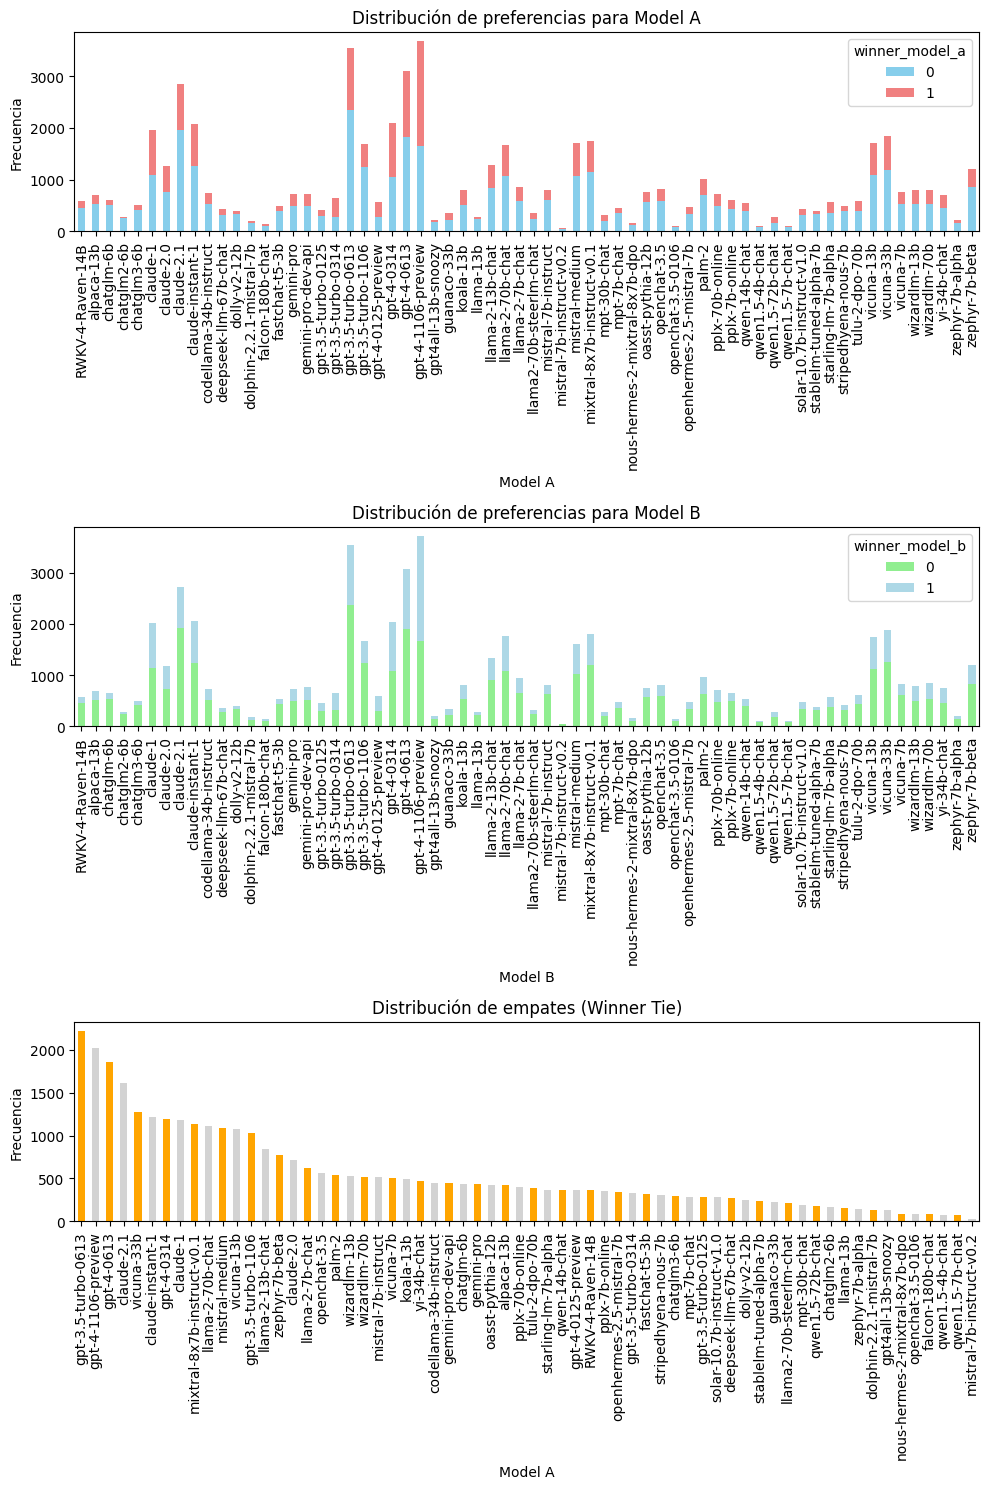

In [102]:
import matplotlib.pyplot as plt
# Enable inline plotting
%matplotlib inline
# Cruce de preferencias con los modelos
cross_a = pd.crosstab(df_train['model_a'], df_train['winner_model_a'])
cross_b = pd.crosstab(df_train['model_b'], df_train['winner_model_b'])
# Concatenar los modelos A y B para evitar duplicados en los empates
all_models_tie = pd.concat([df_train[['model_a', 'winner_tie']],
                            df_train[['model_b', 'winner_tie']].rename(columns={'model_b': 'model_a'})])

# Contar los empates por modelo
tie_counts = all_models_tie[all_models_tie['winner_tie'] == 1]['model_a'].value_counts()

# Gráfico de barras para visualización
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Gráfico para el modelo A
cross_a.plot(kind='bar', stacked=True, ax=axs[0], color=['skyblue', 'lightcoral'])
axs[0].set_title('Distribución de preferencias para Model A')
axs[0].set_xlabel('Model A')
axs[0].set_ylabel('Frecuencia')

# Gráfico para el modelo B
cross_b.plot(kind='bar', stacked=True, ax=axs[1], color=['lightgreen', 'lightblue'])
axs[1].set_title('Distribución de preferencias para Model B')
axs[1].set_xlabel('Model B')
axs[1].set_ylabel('Frecuencia')

# Gráfico para los empates
tie_counts.plot(kind='bar', stacked=True, ax=axs[2], color=['orange', 'lightgrey'])
axs[2].set_title('Distribución de empates (Winner Tie)')
axs[2].set_xlabel('Model A')
axs[2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


In [105]:
a_winners = df_train[['model_a', 'winner_model_a', 'winner_model_b', 'winner_tie']]
b_winners = df_train[['model_b', 'winner_model_a', 'winner_model_b', 'winner_tie']]

a_winners.rename(columns={'model_a': 'model', 'winner_model_a': 'win', 'winner_model_b': 'loss', 'winner_tie': 'tie'}, inplace=True)
b_winners.rename(columns={'model_b': 'model', 'winner_model_a': 'loss', 'winner_model_b': 'win', 'winner_tie': 'tie'}, inplace=True)

winners_df = pd.concat([a_winners, b_winners], ignore_index=True)
winners_df.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_23388\3894222979.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_winners.rename(columns={'model_a': 'model', 'winner_model_a': 'win', 'winner_model_b': 'loss', 'winner_tie': 'tie'}, inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_23388\3894222979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_winners.rename(columns={'model_b': 'model', 'winner_model_a': 'loss', 'winner_model_b': 'win', 'winner_tie': 'tie'}, inplace=True)


,model,win,loss,tie
0,gpt-4-1106-preview,1,0,0
1,koala-13b,0,1,0
2,gpt-3.5-turbo-0613,0,0,1
3,llama-2-13b-chat,1,0,0
4,koala-13b,0,1,0


In [130]:
model_occurrences = winners_df['model'].value_counts()
model_occurrences.head()

model
gpt-4-1106-preview    7387
gpt-3.5-turbo-0613    7083
gpt-4-0613            6165
claude-2.1            5583
claude-instant-1      4136
Name: count, dtype: int64

In [134]:
comparative_result = winners_df.groupby(['model']).sum().reset_index()
comparative_result = comparative_result.merge(model_occurrences, how='inner', on='model')
comparative_result[['win', 'loss', 'tie']] = comparative_result[['win', 'loss', 'tie']].div(comparative_result['count'], axis=0)
comparative_result.head()

,model,win,loss,tie,count
0,RWKV-4-Raven-14B,0.228843,0.461140,0.310017,1158
1,alpaca-13b,0.253742,0.446187,0.300071,1403
2,chatglm-6b,0.172086,0.482950,0.344964,1261
3,chatglm2-6b,0.129433,0.567376,0.303191,564
4,chatglm3-6b,0.158746,0.543984,0.297270,989


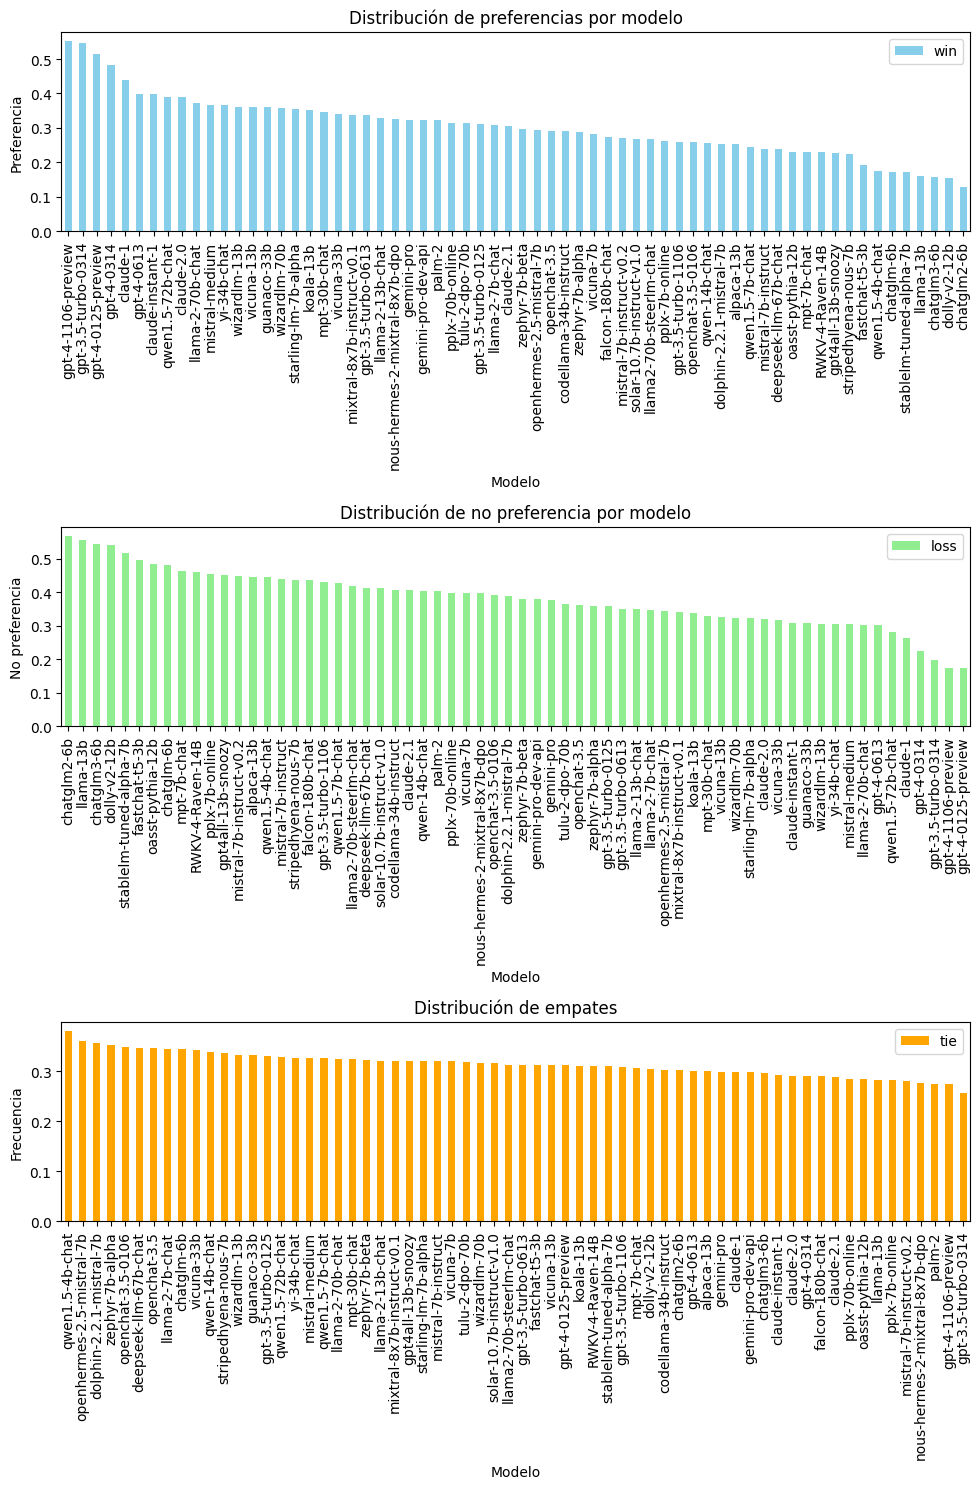

In [135]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Gráfico para el modelo A
comparative_result.sort_values(by=['win'], ascending=False).plot(x='model', y='win',kind='bar', ax=axs[0], color=['skyblue'])
axs[0].set_title('Distribución de preferencias por modelo')
axs[0].set_xlabel('Modelo')
axs[0].set_ylabel('Preferencia')

# Gráfico para el modelo B
comparative_result.sort_values(by=['loss'], ascending=False).plot(x='model', y='loss',kind='bar', ax=axs[1], color=['lightgreen'])
axs[1].set_title('Distribución de no preferencia por modelo')
axs[1].set_xlabel('Modelo')
axs[1].set_ylabel('No preferencia')

# Gráfico para los empates
comparative_result.sort_values(by=['tie'], ascending=False).plot(x='model', y='tie',kind='bar', ax=axs[2], color=['orange'])
axs[2].set_title('Distribución de empates')
axs[2].set_xlabel('Modelo')
axs[2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Los resultados muestran que el modelo gpt-4-1106-preview es consistentemente uno de los más preferidos por los usuarios, con 3678 preferencias en el rol de Model A y 3709 en Model B. Este modelo destaca significativamente en las interacciones, lo que sugiere que sus respuestas son frecuentemente valoradas como las mejores. Le sigue el modelo gpt-3.5-turbo-0613, con un rendimiento igualmente fuerte en ambas posiciones: 3553 preferencias en Model A y 3530 en Model B, lo que lo convierte en un competidor muy robusto.

En cuanto a los empates, gpt-3.5-turbo-0613 lidera con 2217 empates, seguido de cerca por gpt-4-1106-preview con 2027, lo que indica que los usuarios encuentran difícil elegir entre las respuestas de estos dos modelos en muchas ocasiones. Otros modelos relevantes incluyen gpt-4-0613 y claude-2.1, que también reciben una cantidad considerable de preferencias en las tres categorías (Model A, Model B y empates), aunque en menor medida. Por otro lado, modelos como gpt-4-0314 y claude-instant-1 presentan una participación más modesta.

Estos datos sugieren que los modelos GPT, en sus diversas versiones, tienden a dominar en términos de preferencias del usuario, con frecuentes empates entre ellos, lo que resalta la alta calidad y competitividad de sus respuestas.

In [104]:
# Contar cuántas respuestas en total hay de cada modelo en Model A y Model B
model_a_counts = df_train['model_a'].value_counts()
model_b_counts = df_train['model_b'].value_counts()

# Sumar las respuestas de los modelos que aparecen en ambas columnas
total_model_responses = model_a_counts.add(model_b_counts, fill_value=0)

# Ahora sumar las veces que cada modelo aparece en un empate (combinando Model A y Model B)
# Concatenar los modelos para los empates
all_models_tie = pd.concat([df_train[['model_a', 'winner_tie']],
                            df_train[['model_b', 'winner_tie']].rename(columns={'model_b': 'model_a'})])

# Contar los empates por modelo
tie_counts = all_models_tie[all_models_tie['winner_tie'] == 1]['model_a'].value_counts()

# Sumar las veces que cada modelo participó en un empate al conteo total de respuestas
total_model_responses_with_ties = total_model_responses.add(tie_counts, fill_value=0).sort_values(ascending=False)

# Mostrar el total de respuestas por modelo, incluyendo empates
total_model_responses_with_ties.head()


gpt-4-1106-preview    9414
gpt-3.5-turbo-0613    9300
gpt-4-0613            8024
claude-2.1            7197
claude-instant-1      5350
Name: count, dtype: int64

# Análisis del problema

## Situación Problemática
Veamos como en los últimos años ha habido un crecimiento y uso exponencial de los chatbots impulsados por inteligencia artificial. Cada vez más empresas los utilizan para cosas como servicio al cliente, resolución de problemas, ayudar con clases, etc. Esto ha hecho que la demanda para sistemas mejores, más inteligentes, y a la vez más eficientes ha incrementado. Esto entonces nos da paso al problema en cuestión que es, que debemos mejorar las respuestas y el rendimiento de los chatbots, ya que muchas veces sigue siendo necesaria la interacción humana, y los chatbots no son capaces de manejar problemas o situaciones complejas.

## Problema científico
El problema en este caso es de qué manera podemos evaluar y mejorar a los chatbots para que estos elaboren siempre contenido relevante, coherente, que tenga que ver con la situación y el contexto que se le están proveyendo, que suene de forma natural. De modo que de alguna manera debemos ser capaces de comparar y evaluar a estos Chatbots, como en la Chatbot Arena para lograr hacer esto de manera eficiente

## Objetivos
### Objetivo General
Lograr identificar patrones a nivel general que nos indiquen qué tipo de respuestas son las que los usuarios suelen preferir
### Objetivos específicos
- Identificar, si dentro de los chatbots datos existe uno que sea mucho más dominante que los otros
- Diseñar métricas efectivas para poder evaluar las respuestas de los diferentes chatbots y poder así determinar cuál es la preferente por el usuario.
- Utilizar distintas técnicas de Machine Learning para identificar cuál es la más efectiva para realizar las evaluaciones y las predicciones

# Registro de Cambios
